### Replot some decoding figures, formatted in a way for the grant

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils

import os
import pandas as pd
import matplotlib

In [2]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_scratch/pseudo"

SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

Text(0, 0.5, 'Decoder Accuracy')

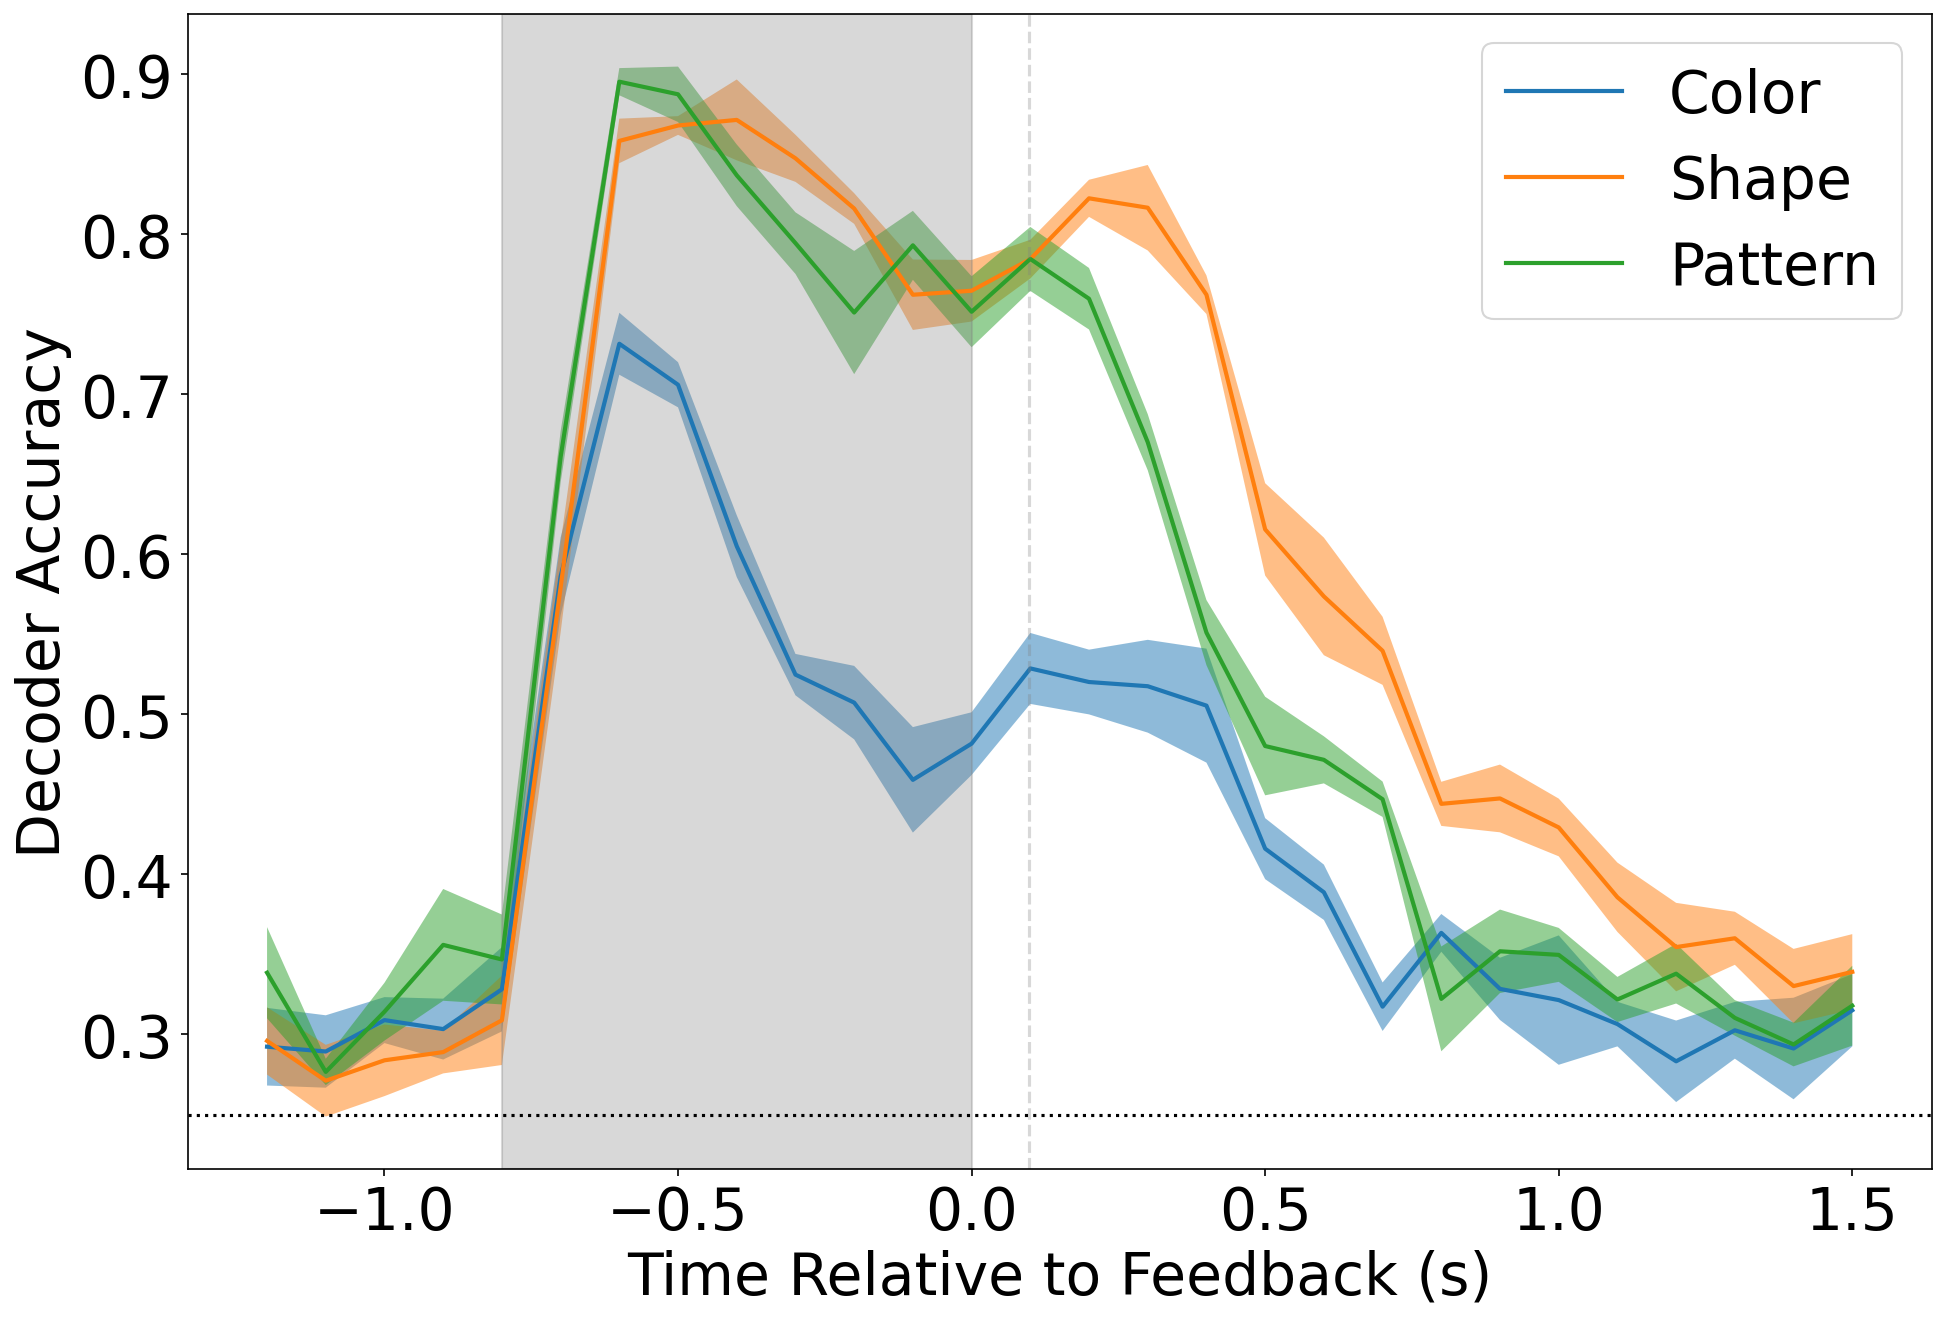

In [3]:
matplotlib.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(dpi=150, figsize=(15, 10))
for feature_dim in FEATURE_DIMS:
    # load the test accuracy of generated from the decode_features_with_pseudo.py script
    # here I'm just visualizing test accuracy, but can very well visualize train/shuffled as well. 
    test_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_test_accs.npy"))
    # plots the mean and standard deviation of decoding accuracy across splits, by time. 
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature_dim}",
        right_align=True, 
    )
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### 

### Generate combined weights plot

In [4]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(valid_sess)
positions = positions[positions.manual_structure != "unknown"]

In [5]:
positions.manual_structure.unique()

array(['Parietal Cortex', 'Premotor Cortex', 'Prefrontal Cortex',
       'Anterior Cingulate Gyrus', 'Claustrum', 'Amygdala',
       'Hippocampus/MTL', 'Basal Ganglia', 'Visual Cortex'], dtype=object)

In [8]:
fig = visualization_utils.generate_glass_brain(positions, "manual_structure", name_to_color=visualization_utils.REGION_TO_COLOR)
# directly write this figure as a html file. 
# ran into performance issues displaying the glass brain within the notebook
fig.write_html("/data/patrick_scratch/pseudo/figs/units_glass_brain_estimated_manual_struc_less_manual_colors_legend.html")

In [9]:
normalizeds = []
for i, feature_dim in enumerate(FEATURE_DIMS):
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_models.npy"), allow_pickle=True)
    # evaluate weights by time. Pass in number of neurons and number of classes
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=1117, num_classes=4)
    # normalize weights so that they sum to 1
    sums = np.sum(weights, axis=0)
    normalized = weights / sums
    normalizeds.append(normalized)
all_weights = np.concatenate(normalizeds, axis=1)
means = np.mean(all_weights, axis=1)
means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})

[  75.5  171.5  253.5  340.5  549.5  678.5  984.5 1053.5]
10
[  75.5  171.5  253.5  340.5  549.5  678.5  984.5 1053.5]
10
[  75.5  171.5  253.5  340.5  549.5  678.5  984.5 1053.5]
10


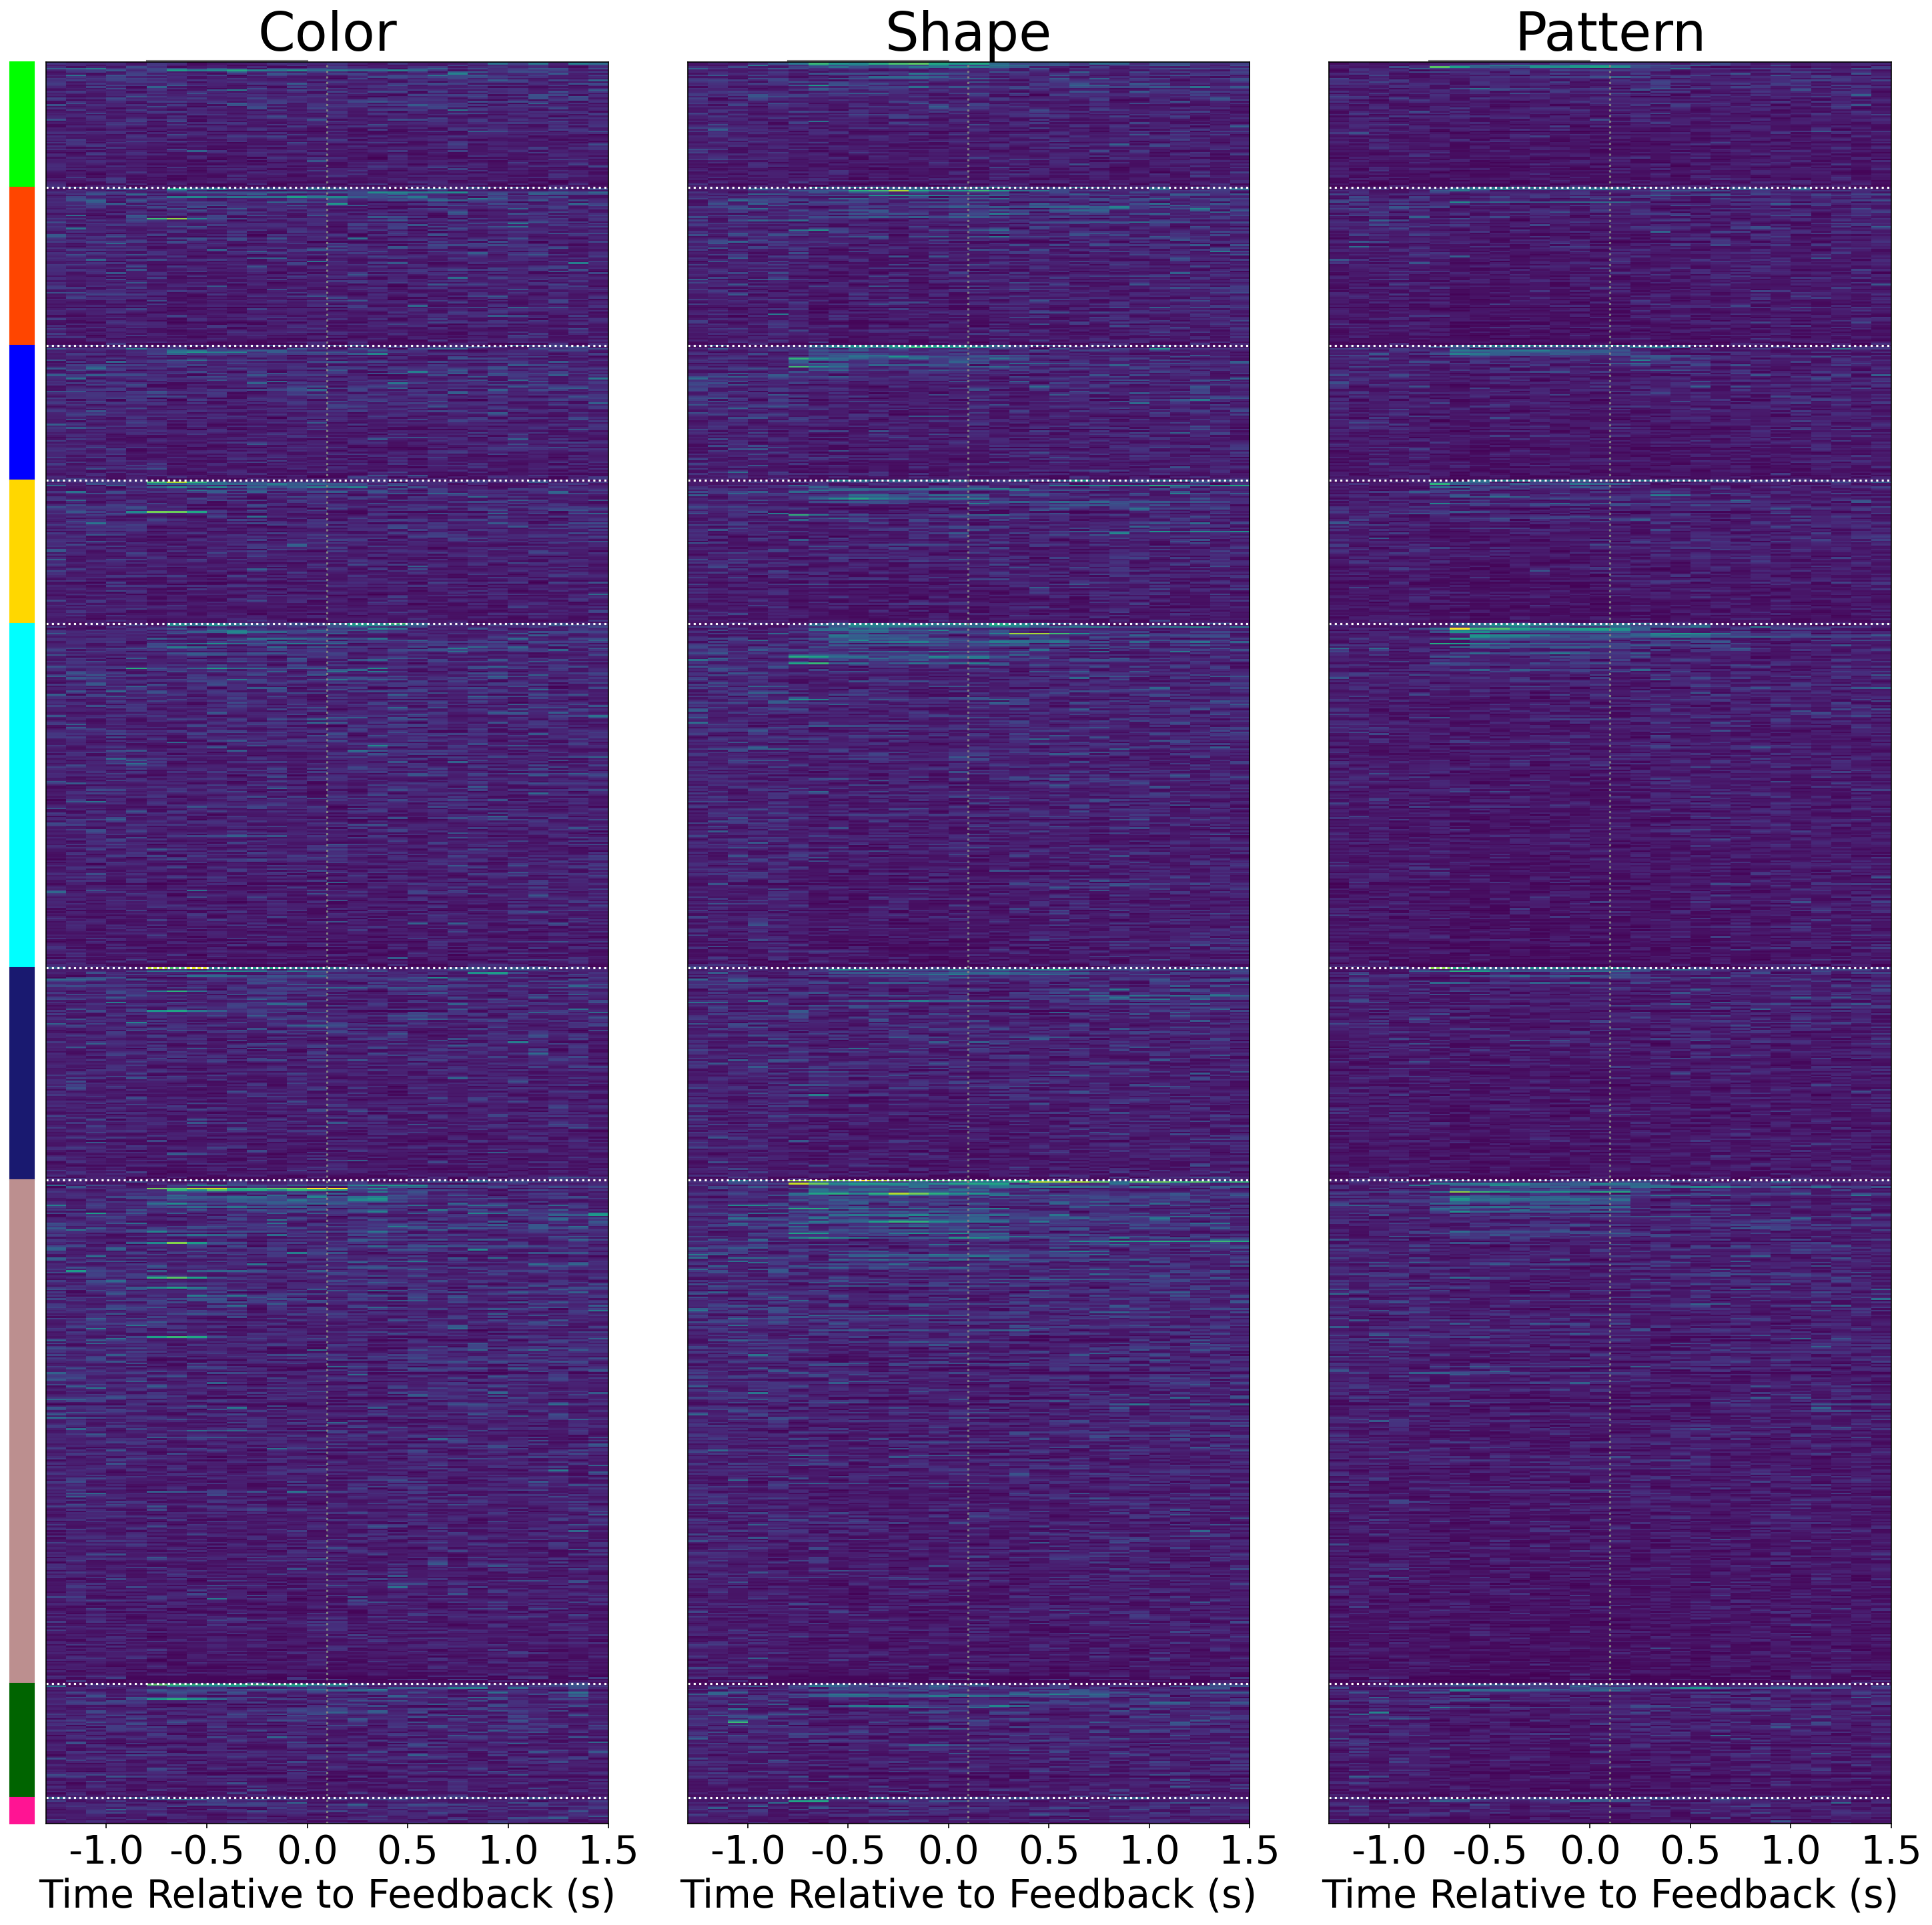

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20), dpi=150, sharex=True)
matplotlib.rcParams.update({'font.size': 32})
for i, feature_dim in enumerate(FEATURE_DIMS):
    add_region = i == 0
    visualization_utils.visualize_weights(
        positions, 
        normalizeds[i], 
        "manual_structure", 
        name_to_color=visualization_utils.REGION_TO_COLOR, 
        add_region=add_region, 
        mean_weights_df=means_df,
        ax=axs[i]
    )
    axs[i].set_title(feature_dim)
# plt.xlabel("Time Relative to Feedback (s)")
fig.tight_layout()

### Same figures, but for feedback 

Text(0, 0.5, 'Decoder Accuracy')

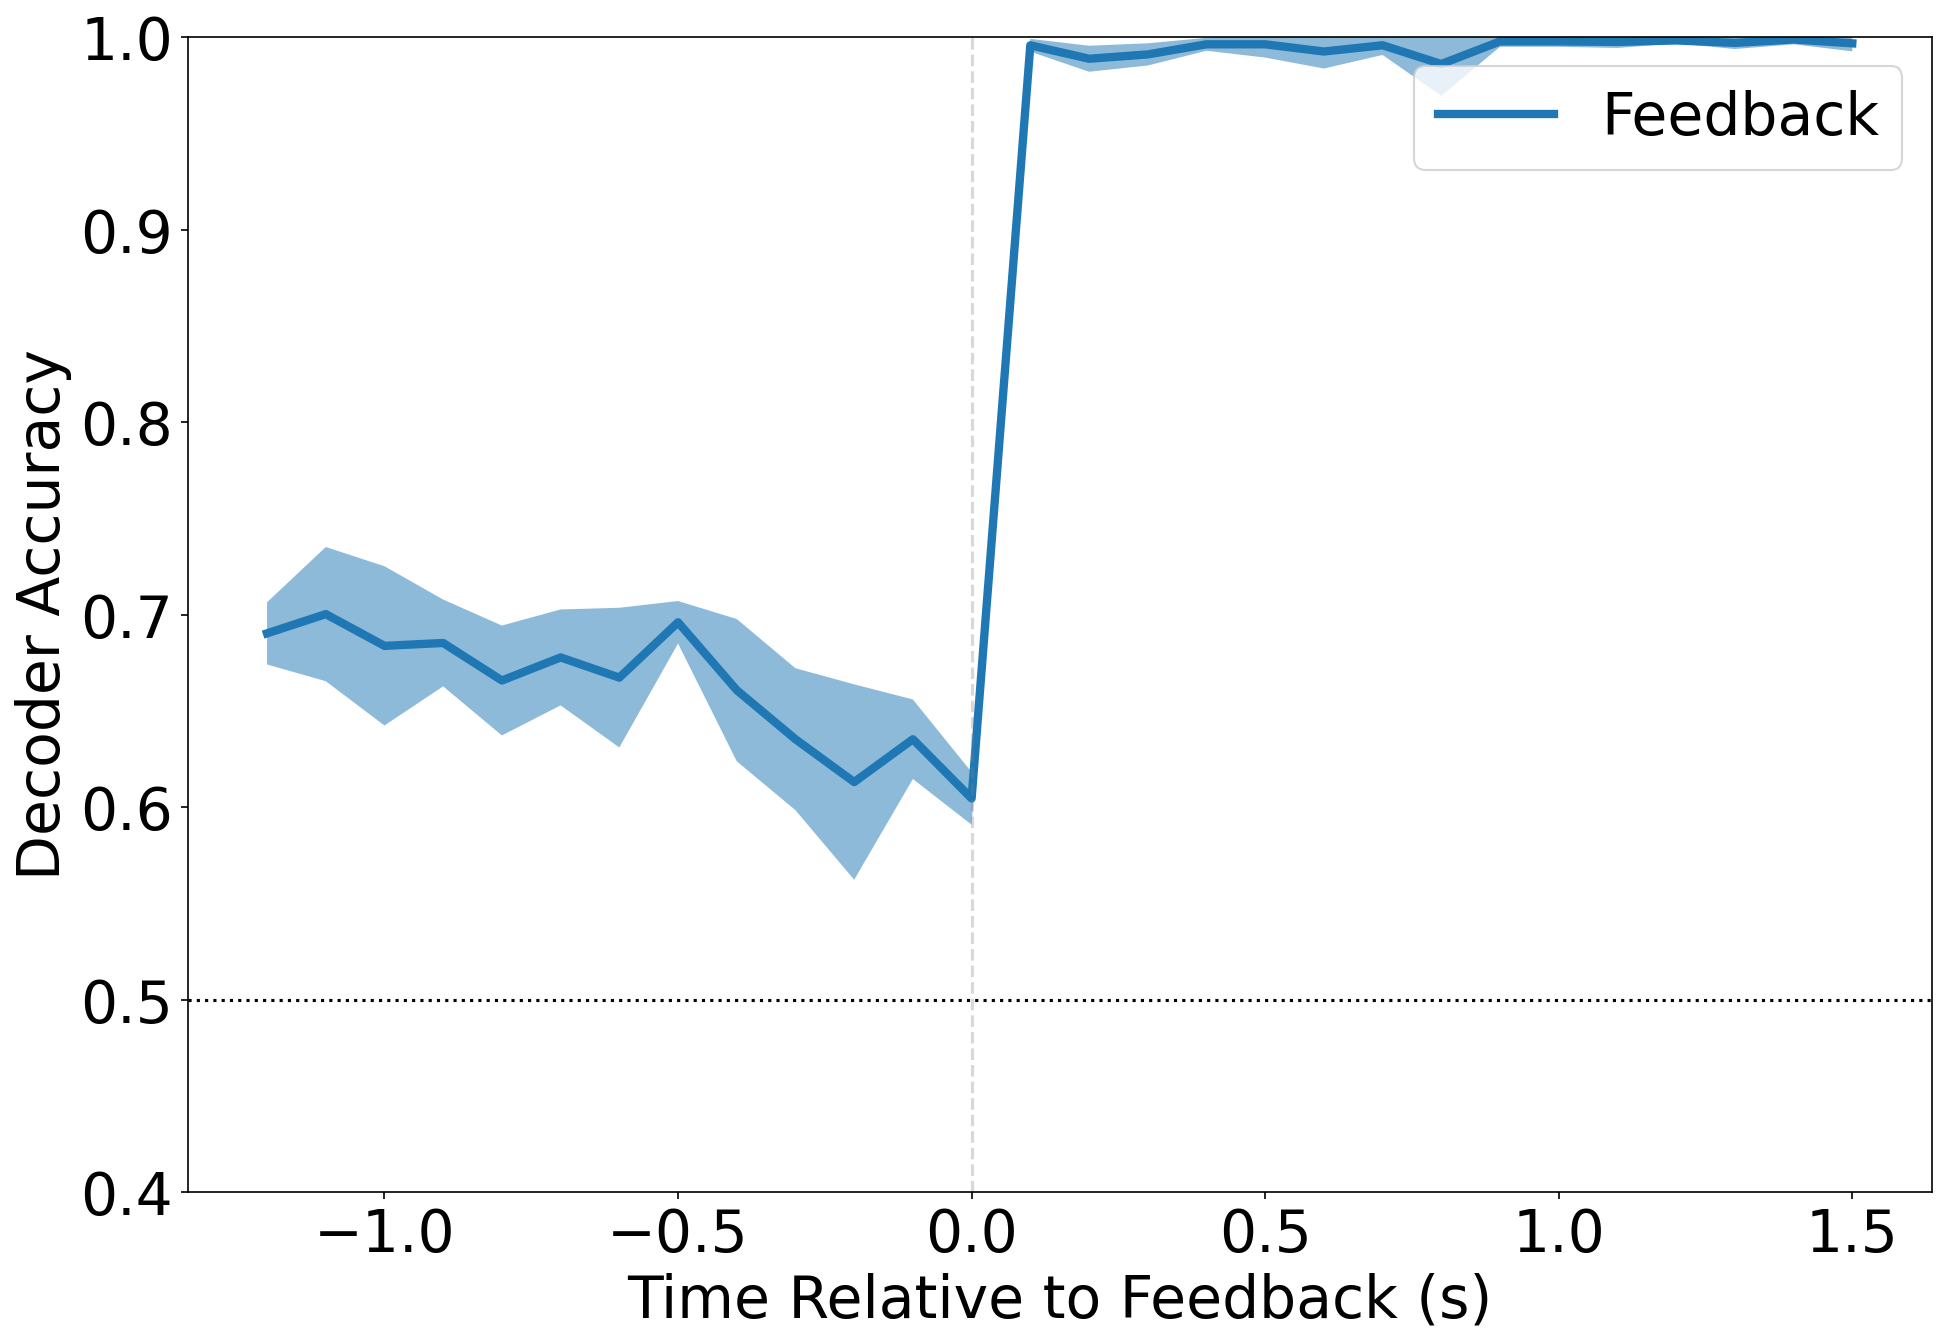

In [23]:
matplotlib.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(dpi=150, figsize=(15, 10))
# load the test accuracy of generated from the decode_features_with_pseudo.py script
# here I'm just visualizing test accuracy, but can very well visualize train/shuffled as well. 
test_accs = np.load(os.path.join(OUTPUT_DIR, f"feedback_test_accs.npy"))
# plots the mean and standard deviation of decoding accuracy across splits, by time. 
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Feedback",
    right_align=True, 
)
ax.legend()
# add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.0, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_ylim([0.4, 1])
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

In [30]:
normalizeds = []
models = np.load(os.path.join(OUTPUT_DIR, f"feedback_models.npy"), allow_pickle=True)
# evaluate weights by time. Pass in number of neurons and number of classes
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=1117, num_classes=2)
# normalize weights so that they sum to 1
sums = np.sum(weights, axis=0)
normalized = weights / sums
means = np.mean(normalized, axis=1)
means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})

In [31]:
positions = positions.reset_index()

[ 37.5  85.5 126.5 169.5 273.5 337.5 490.5 524.5]
10


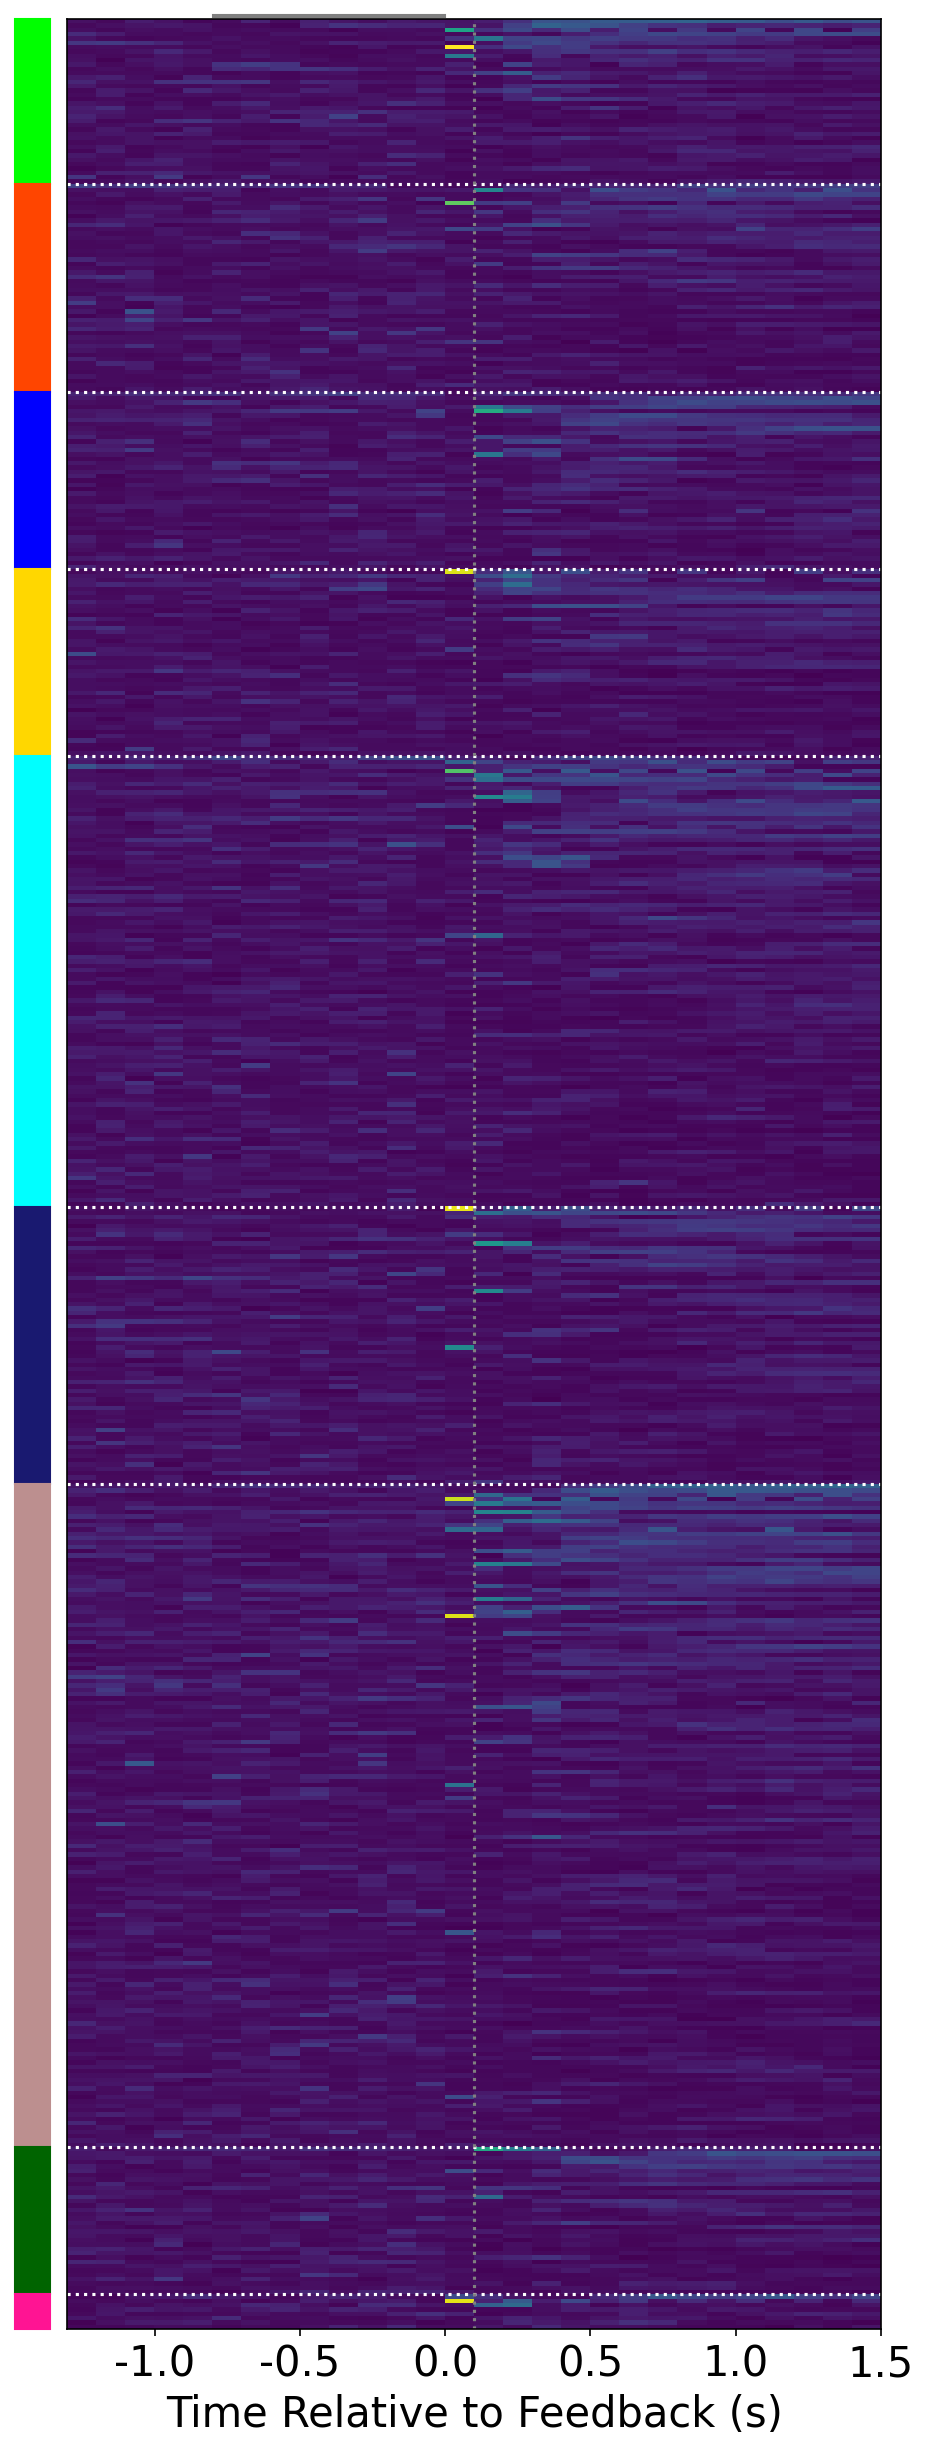

In [36]:
fig, ax = plt.subplots(figsize=(7, 20), dpi=150, sharex=True)
matplotlib.rcParams.update({'font.size': 20})
visualization_utils.visualize_weights(
    positions, 
    normalized, 
    "manual_structure", 
    name_to_color=REGION_TO_COLOR, 
    add_region=True, 
    mean_weights_df=means_df,
    ax=ax, 
    fig=fig
)
# ax.set_title("Feedback")
# plt.xlabel("Time Relative to Feedback (s)")
